In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

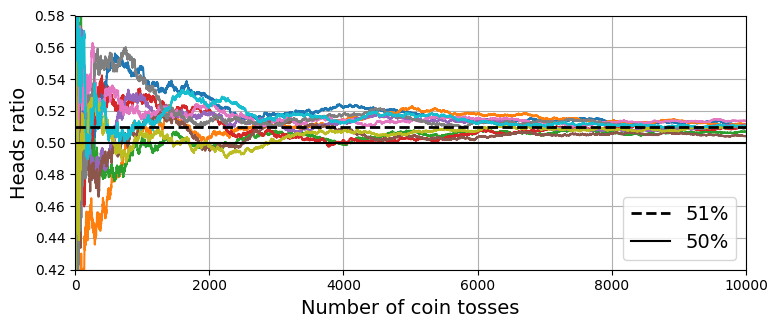

In [5]:
import matplotlib.pyplot as plt
import numpy as np

heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()
save_fig("law_of_large_numbers_plot")
plt.show()

In [6]:
# using ensamble method
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# 
X, y = make_moons(n_samples=500, noise=0.30)
X_train, X_test, y_train, y_test = train_test_split(X, y)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression()),
        ('rf', RandomForestClassifier()),
        ('svc', SVC())
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [7]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

# these are the individual scores for each classifiers

lr = 0.816
rf = 0.856
svc = 0.88


In [8]:
voting_clf.predict(X_test[:1])

array([1])

In [9]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([1])]

In [10]:
voting_clf.score(X_test, y_test)


0.864

In [11]:
# If all classifiers are able to estimate class probabilities (i.e., they have a predict_proba() method), then you can 
# tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called soft voting

# We can also use soft voting to achieve slightly better results
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)
# the previous result was set to "hard"
#  It often achieves higher performance than hard voting because it gives more weight to highly confident votes.

0.872

# Bagging and Pasting

- One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed. Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set. When sampling is performed with replacement, this method is called `bagging`.
- When sampling is performed without replacement, it is called `pasting`.

In [12]:
# training an ensemble of 500 Decision tree classifiers, each trained on 100 training 
# instances randomly sampled from training set with replacement
# n_job parameter tells scikitlearn the number of CPU cores to use for training and predictions

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(        # BaggingClassifier automatically performs soft voting instead of hard voting
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1) # n_jobs=-1 means we using all cores

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)


# Random Forests

- `Random forest` is an `ensemble` of `Decision Trees`
- Generally Trained via `bagging` method
    - Typically with `max_samples` set to the size of the training model

- Instead of building a BaggingClassifier and passing it a DecisionTreeClassifier, we can instead use the RandomForestClassifier class, which is more convenient and optimized for Decision Trees

In [13]:
# training a Random Forest classifier with 500 trees (each limited to maximum 16 nodes), using all available CPU cores:

from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)


# Feature Importance

Yet another great quality of Random Forests is that they make it easy to measure the relative importance of each feature
- `Scikit-Learn` measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average
- it is weighted average, where each node's weight is equal to number of training data samples that are asscociated with it
- Random Forests are very handy to get a quick understanding of what features actually matter, in particular if you need to perform feature selection.

In [14]:
# Using extra features on the iris dataset

from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.08892895064195988
sepal width (cm) 0.026144234043566302
petal length (cm) 0.4383241728199122
petal width (cm) 0.44660264249456166


# Boosts
`Boosting` refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor

Types of Boosts:
-   `AdaBoost`
-   `Gradient Boosting`

# `AdaBoosts`

- Basically training a first classifier, seeing where it doesn't do well
- Add more weight where it didn't do well
- Train second class classifier based on the weights from resulting first trained set
- increase weights in missed data points
- Until model is good enough.

In [15]:
# Example of AdaBoost on moon dataset
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5
)

ada_clf.fit(X_train, y_train)

C:\Users\Dell Optiplex 3070\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

# Gradient Boosting

In [25]:
# Gradient boost with Decision Trees
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [26]:
# Now training the second decision tree
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [27]:
# training the third regression
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

In [28]:
# now we have an ensemble containing three trees
# we can make predictions on a new instance simply by adding up the predictions of all 3
import numpy as np
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

# Stacking